In [1]:
from __future__ import print_function

import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Embedding, LSTM, TimeDistributed, Dense
from keras.models import Model, load_model

# To import 'katakana' from relative path
sys.path.append(os.path.abspath(os.path.join('..')))
from katakana import encoding

INPUT_LENGTH = 22
OUTPUT_LENGTH = 22


Using TensorFlow backend.


# Data pre-processing

In [2]:
with open('../data/dataset_random.txt', 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

data_input=[]
data_output=[]
        
for line in lines:
    input_text, target_text = line.split(' ')
    #if(len(input_text)>20 and len(target_text)>20):
     #   print(input_text+" "+target_text)
    data_input.append(input_text)
    data_output.append(target_text)
    
print(data_input[1],data_output[1])    

রাজ্যগুলোর রাজ্য


In [3]:
#data = pd.read_csv('../data/joined_titles.csv', header=None)
#data = data.sample(frac=1, random_state=0)

########################data_input = [s.decode('utf-8').lower() for s in data[0]]
########################data_output = [s.decode('utf-8') for s in data[1]]

#data_input = [s.lower() for s in data[0]]
#data_output = [s for s in data[1]]

#print(data_input[0], data_output[0])
#print(data_input[5], data_output[5])


data_size = len(data_input)

# We will use the first 0-60th %-tile (60%) of data for the training
training_input  = data_input[int(data_size*0/100):int(data_size*80/100)]
training_output = data_output[int(data_size*0/100):int(data_size*80/100)]

# We will use the first 60-70th %-tile (10%) of data for the training
validation_input = data_input[int(data_size*80/100):int(data_size*100/100)]
validation_output = data_output[int(data_size*80/100):int(data_size*100/100)]

print('training size', len(training_input))
print('validation size', len(validation_input))

training size 26011
validation size 6503


### Transform data into Numpy arrays

We transform the sequences of characters into sequences of integer IDs. This will be done by using pre-written functions in `encoding` module. 
- First, `encoding.build_characters_encoding` will build encoding/decoding dictionary from the data. 
- Then, `encoding.transform` will transform the data into numpy array.

Check [the previous notebook](./Writing Katakana using Sequence-to-Sequence in Keras) for the details about the transformation.

In [4]:
input_encoding, input_decoding, input_dict_size = encoding.build_characters_encoding(data_input)
output_encoding, output_decoding, output_dict_size = encoding.build_characters_encoding(data_output)

print('Input character dict size:', input_dict_size)
print('Output character dict size:', output_dict_size)

encoded_training_input = encoding.transform(
    input_encoding, training_input, vector_size=INPUT_LENGTH)
encoded_training_output = encoding.transform(
    output_encoding, training_output, vector_size=OUTPUT_LENGTH)

print('encoded_training_input', encoded_training_input.shape)
print('encoded_training_output', encoded_training_output.shape)

encoded_validation_input = encoding.transform(
    input_encoding, validation_input, vector_size=INPUT_LENGTH)
encoded_validation_output = encoding.transform(
    output_encoding, validation_output, vector_size=OUTPUT_LENGTH)

print('encoded_validation_input', encoded_validation_input.shape)
print('encoded_validation_output', encoded_validation_output.shape)

Input character dict size: 79
Output character dict size: 78
encoded_training_input (26011, 22)
encoded_training_output (26011, 22)
encoded_validation_input (6503, 22)
encoded_validation_output (6503, 22)


# Sequence-to-Sequence in Keras

In [5]:
encoder_input = Input(shape=(INPUT_LENGTH,))
decoder_input = Input(shape=(OUTPUT_LENGTH,))

### Encoder / Decoder

In [6]:
from keras.layers import SimpleRNN

encoder = Embedding(input_dict_size, 64, input_length=INPUT_LENGTH, mask_zero=True)(encoder_input)
encoder = LSTM(64, return_sequences=True, unroll=True)(encoder)
encoder_last = encoder[:,-1,:]

print('encoder', encoder)
print('encoder_last', encoder_last)

decoder = Embedding(output_dict_size, 64, input_length=OUTPUT_LENGTH, mask_zero=True)(decoder_input)
decoder = LSTM(64, return_sequences=True, unroll=True)(decoder, initial_state=[encoder_last, encoder_last])

print('decoder', decoder)

encoder Tensor("lstm_1/transpose_2:0", shape=(?, 22, 64), dtype=float32)
encoder_last Tensor("strided_slice:0", shape=(?, 64), dtype=float32)
decoder Tensor("lstm_2/transpose_2:0", shape=(?, 22, 64), dtype=float32)


### Attention Mechanism

Reference: 
[Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/pdf/1508.04025.pdf)'s 
**Global Attention** with **Dot**-based scoring function (Section 3, 3.1)


In [7]:
from keras.layers import Activation, dot, concatenate

# Equation (7) with 'dot' score from Section 3.1 in the paper.
# Note that we reuse Softmax-activation layer instead of writing tensor calculation
attention = dot([decoder, encoder], axes=[2, 2])
attention = Activation('softmax', name='attention')(attention)
print('attention', attention)

context = dot([attention, encoder], axes=[2,1])
print('context', context)

decoder_combined_context = concatenate([context, decoder])
print('decoder_combined_context', decoder_combined_context)

# Has another weight + tanh layer as described in equation (5) of the paper
output = TimeDistributed(Dense(64, activation="tanh"))(decoder_combined_context)
output = TimeDistributed(Dense(output_dict_size, activation="softmax"))(output)
print('output', output)


attention Tensor("attention/truediv:0", shape=(?, 22, 22), dtype=float32)
context Tensor("dot_2/MatMul:0", shape=(?, 22, 64), dtype=float32)
decoder_combined_context Tensor("concatenate_1/concat:0", shape=(?, 22, 128), dtype=float32)
output Tensor("time_distributed_2/Reshape_1:0", shape=(?, 22, 78), dtype=float32)


In [13]:
model = Model(inputs=[encoder_input, decoder_input], outputs=[output])
model.compile(optimizer='adamax', loss='categorical_crossentropy',metrics=['accuracy'])

## Training the model

In [14]:
training_encoder_input = encoded_training_input
training_decoder_input = np.zeros_like(encoded_training_output)
training_decoder_input[:, 1:] = encoded_training_output[:,:-1]
training_decoder_input[:, 0] = encoding.CHAR_CODE_START
training_decoder_output = np.eye(output_dict_size)[encoded_training_output.astype('int')]

validation_encoder_input = encoded_validation_input
validation_decoder_input = np.zeros_like(encoded_validation_output)
validation_decoder_input[:, 1:] = encoded_validation_output[:,:-1]
validation_decoder_input[:, 0] = encoding.CHAR_CODE_START
validation_decoder_output = np.eye(output_dict_size)[encoded_validation_output.astype('int')]

In [15]:
if os.path.isfile('model.h5'):
    model = load_model('model.h5')
else:
    history=model.fit(x=[training_encoder_input, training_decoder_input], y=[training_decoder_output],
          validation_data=([validation_encoder_input, validation_decoder_input], [validation_decoder_output]),
          verbose=2, batch_size=64, epochs=15) #epochs=30)
                      
history=model.fit(x=[training_encoder_input, training_decoder_input], y=[training_decoder_output],
          validation_data=([validation_encoder_input, validation_decoder_input], [validation_decoder_output]),
          verbose=2, batch_size=64, epochs=5)

model.save('model.h5')

Train on 26011 samples, validate on 6503 samples
Epoch 1/15
 - 82s - loss: 2.6680 - acc: 0.3144 - val_loss: 2.3212 - val_acc: 0.3978
Epoch 2/15
 - 48s - loss: 2.1302 - acc: 0.4383 - val_loss: 1.9755 - val_acc: 0.4721
Epoch 3/15
 - 48s - loss: 1.7940 - acc: 0.5138 - val_loss: 1.6334 - val_acc: 0.5533
Epoch 4/15
 - 48s - loss: 1.5111 - acc: 0.5816 - val_loss: 1.3920 - val_acc: 0.6136
Epoch 5/15
 - 48s - loss: 1.2668 - acc: 0.6466 - val_loss: 1.1523 - val_acc: 0.6768
Epoch 6/15
 - 48s - loss: 1.0710 - acc: 0.6972 - val_loss: 0.9992 - val_acc: 0.7155
Epoch 7/15
 - 48s - loss: 0.9073 - acc: 0.7414 - val_loss: 0.8369 - val_acc: 0.7581
Epoch 8/15
 - 48s - loss: 0.7839 - acc: 0.7757 - val_loss: 0.7505 - val_acc: 0.7855
Epoch 9/15
 - 48s - loss: 0.6882 - acc: 0.8020 - val_loss: 0.6445 - val_acc: 0.8115
Epoch 10/15
 - 48s - loss: 0.6027 - acc: 0.8261 - val_loss: 0.5783 - val_acc: 0.8326
Epoch 11/15
 - 48s - loss: 0.5307 - acc: 0.8467 - val_loss: 0.4973 - val_acc: 0.8563
Epoch 12/15
 - 47s - loss

C:\Users\RANA_CSE\Anaconda3\lib\site-packages\keras\engine\topology.py:2361: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'strided_slice:0' shape=(?, 64) dtype=float32>, <tf.Tensor 'strided_slice:0' shape=(?, 64) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


### Testing the model


In [16]:
def generate(text):
    encoder_input = encoding.transform(input_encoding, [text.lower()], 22)
    decoder_input = np.zeros(shape=(len(encoder_input), OUTPUT_LENGTH))
    decoder_input[:,0] = encoding.CHAR_CODE_START
    for i in range(1, OUTPUT_LENGTH):
        output = model.predict([encoder_input, decoder_input]).argmax(axis=2)
        decoder_input[:,i] = output[:,i]
    return decoder_input[:,1:]

def decode(decoding, sequence):
    text = ''
    for i in sequence:
        if i == 0:
            break
        text += output_decoding[i]
    return text

def to_stem(text):
    decoder_output = generate(text)
    return decode(output_decoding, decoder_output[0])


common_american_names = ['James', 'John', 'Robert', 'Mary', 'Patricia', 'Linda']

common_american_names=['Unschooling',
'Lovosice',
'Milch',
'Juva',
'Brembilla',
'Sa Pa',
'Brumano',
'Brusaporto',
'Deventer',
'Enschede']

common_american_names=['এই বটের আশ্রয়ে',
'ঐ বটের ছায়ায়',
'বটে! বটে! বটে!',
'বিচিত্র বটে! লাল',
'১২ই মে ২০২৫',
'আজ মে মাস',
'হাসিতে মেতে উঠল' ]

#for name in common_american_names:
 #   print(name, to_katakana(name))

In [18]:
#print(to_katakana('সাদা লাল নীল'))
#print(to_katakana('Peter Parker'))
#print(to_katakana('Jonny Snow'))

with open('../data/stemmer_dataset.txt', 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

    count=0
for line in lines[34905: 35005]:
    test_input_text, test_target_text = line.split(' ')
    test_output_text=to_stem(test_input_text)
    print(test_input_text+"------"+test_output_text)
    if(test_output_text==test_target_text):
        count+=1
        
print((count*100)/100)        

ডাকাতরা------ডাকাতরা
কারুপণ্যে------কারুপণ্য
ওভারেই------ওভার
হীরাকে------হীরা
রানে------রান
হোসেনেরও------হোসেন
ওভারের------ওভার
হাউসটির------হাউস
শেরপাদের------শেরপা
চম্পকারই------পৌমত্চ
এডিনবরার------এডিনবরা
সক্ষমতাই------সক্ষমতা
রাইডারকে------রাইডার
ভাগ্নেদের------ভাগ্নে
জুরিখে------জুরিখে
সক্ষমতাও------সক্ষমতা
আগুয়েরোকে------আগুয়েরো
শব্দটির------অতেপ্স
ছাত্রশিবিরেরটা------ছাত্রচিনফি
তনুময়ের------তনুময়
শব্দটিও------অত্লফ
শব্দটার------অনুংকোড়
শব্দটিই------অত্লফ
পালংখালীতে------পালউদলাতি
শব্দটাও------অনোষুং
লালনগীতির------লালনগীতন
চেসের------চেস
রাতই------রাত
আদর্শকে------আদর্শ
সক্ষমতার------সক্ষমতা
রাতও------রাত
মেরিকে------মেরি
মিশনারিরা------মিশনারি
কোম্পানিকেও------ক্ল্মহান্র
পাবনায়ও------পাবনায়
র‌্যাবের------রৌভাবু
কোম্পানিকেই------ক্ল্যিমনো
খাজানগরের------খাজানগর
নিভৃতে------নিভৃত
কনসোলটিকে------কনসোল
মোহাম্মদের------মালবিবাজ্ডো
ডাকাতের------ডাকাত
স্বাধীনতাকামীরাও------স্বাধনীতাক্যী
আফগানিস্তানেও------আফগানিস্না
সাপের------সাপ
মৎস্যজীবীরা------মেপবসাবনাভায়
দীপ্রটা------দীপ্র
আফ

# Visualize Attention

The next step is visualizing the attention values of the medel during the translation. 

To do that, the first step is to locate "attention" layer of the model. The attention layer is the 7th layers of the model (`model.layers[7]`), which is the softmax activation-layer after dot-score. Or we can also simply call `model.get_layer('attention')` as we previously name the layer as "attention".

In [32]:
layers = model.layers
for l in layers:
    print('%s\tname:%s' % (str(l), l.name))
    
assert(model.layers[7] == model.get_layer('attention'))

<keras.engine.topology.InputLayer object at 0x0000004C909BDA20>	name:input_2
<keras.engine.topology.InputLayer object at 0x0000004C909BDB00>	name:input_1
<keras.layers.embeddings.Embedding object at 0x0000004C94FE9A58>	name:embedding_2
<keras.layers.embeddings.Embedding object at 0x0000004C9264A358>	name:embedding_1
<keras.layers.recurrent.LSTM object at 0x0000004C94FC0F28>	name:lstm_2
<keras.layers.recurrent.LSTM object at 0x0000004C9264A320>	name:lstm_1
<keras.layers.merge.Dot object at 0x0000004C9006DA90>	name:dot_1
<keras.layers.core.Activation object at 0x0000004C9006DEB8>	name:attention
<keras.layers.merge.Dot object at 0x0000004C9619CA90>	name:dot_2
<keras.layers.merge.Concatenate object at 0x0000004C961B5B00>	name:concatenate_1
<keras.layers.wrappers.TimeDistributed object at 0x0000004C961BFA20>	name:time_distributed_1
<keras.layers.wrappers.TimeDistributed object at 0x0000004C961E7048>	name:time_distributed_2


We also need to re-build the model so that it returns the output from the attention layer in addition to the normal output.

In [33]:
attention_layer = model.get_layer('attention') # or model.layers[7]
attention_model = Model(inputs=model.inputs, outputs=model.outputs + [attention_layer.output])

print(attention_model)
print(attention_model.output_shape)

[(None, 20, 100), (None, 20, 20)]


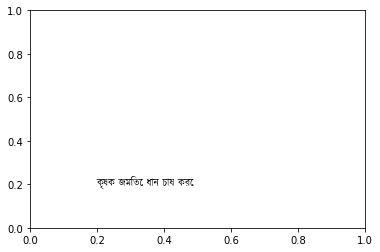

In [37]:
# for testing

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

prop = fm.FontProperties(fname='kalpurush.ttf')
s = "কৃষক জমিতে ধান চাষ করে"
x = 0.2
y = 0.2
plt.text(x, y, s, fontproperties=prop)
plt.show()

In [38]:
%matplotlib inline  
import matplotlib
import matplotlib.pyplot as plt
import seaborn

#banglar jonno kon font bhalo hoy oita thik korte hobe
seaborn.set(font=['kalpurush.ttf'], font_scale=3)

def attent_and_generate(text):
    encoder_input = encoding.transform(input_encoding, [text.lower()], 20)
    decoder_input = np.zeros(shape=(len(encoder_input), OUTPUT_LENGTH))
    decoder_input[:,0] = encoding.CHAR_CODE_START
    
    for i in range(1, OUTPUT_LENGTH):
        output, attention = attention_model.predict([encoder_input, decoder_input])
        decoder_input[:,i] = output.argmax(axis=2)[:,i]
        attention_density = attention[0]
        decoded_output = decode(output_decoding, decoder_input[0][1:])
        
    return attention_density, decoded_output


def visualize(text):
    attention_density, katakana = attent_and_generate(text)

    plt.clf()
    plt.figure(figsize=(28,12))
    
    ax = seaborn.heatmap(attention_density[:len(katakana) + 2, : len(text) + 2],
        xticklabels=[w for w in text],
        yticklabels=[w for w in katakana])

    ax.invert_yaxis()
    plt.show()


C:\Users\RANA_CSE\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['kalpurush.ttf'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


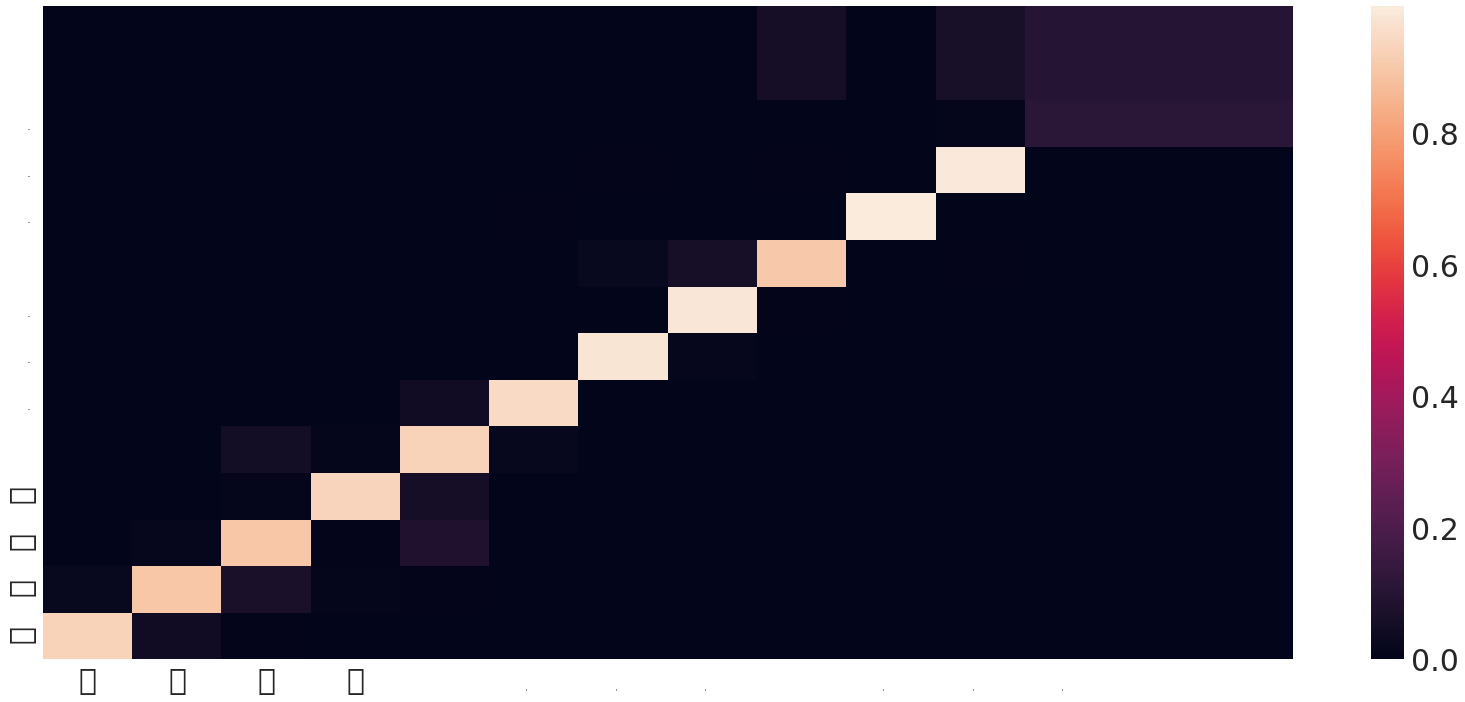

In [39]:
visualize('সাদা লাল নীল')

C:\Users\RANA_CSE\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['Osaka'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


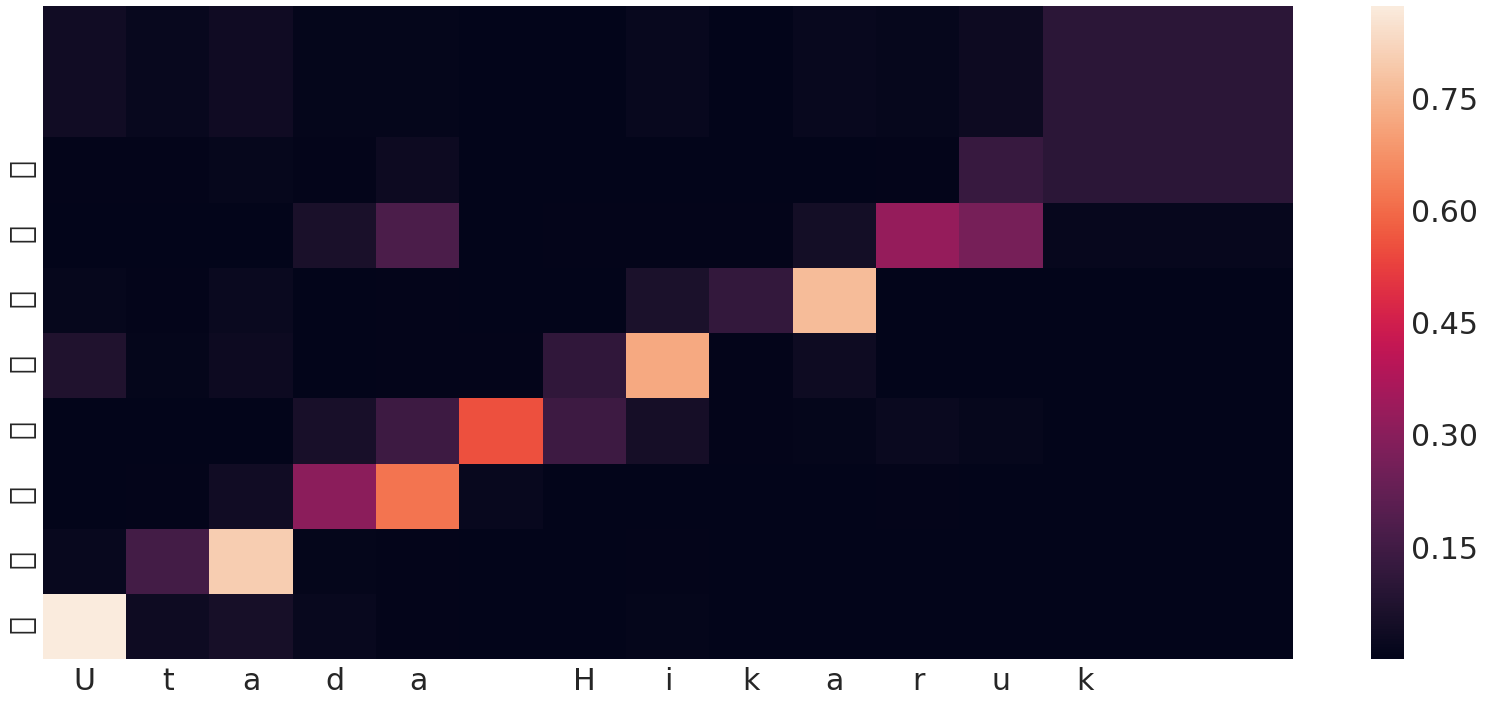

In [23]:
visualize('Utada Hikaruk')

In [11]:
visualize('Harry Potter')

NameError: name 'visualize' is not defined

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


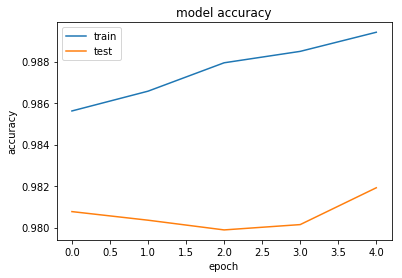

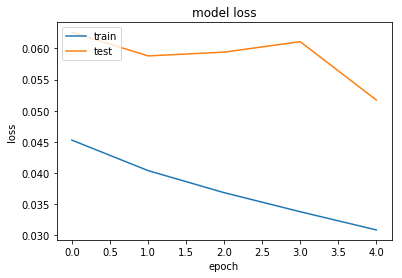

In [12]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()